# Notebook 4 — Modeling & Evaluation

**Goal**  
Train baseline and advanced models to predict ad click-through rate (CTR) using the merged dataset.
We will:
1) define clean feature sets,
2) create robust train/validation splits,
3) build a logistic regression baseline with proper normalization and class imbalance handling,
4) evaluate with appropriate metrics (ROC-AUC, PR-AUC, LogLoss, F1, Recall, Precision),
5) prepare for tree-based models (LightGBM/XGBoost) and feature pruning in later steps.

**Data inputs**  
- `outputs_merged/train_merged.parquet`  
- `outputs_merged/test_merged.parquet`

## 4.1 Load Data, Build Feature Set, and Create Train/Validation Split

We will:
- load the merged training data,
- keep numeric features only (to avoid exploding one-hot dimensions in the baseline),
- drop IDs/raw string columns,
- create a stratified train/validation split that preserves the natural class imbalance,
- prepare a reusable evaluation function for consistent reporting.

In [9]:
# === 4.1 Load data & prepare split ===
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Load merged training data
train_path = "outputs_merged/train_merged.parquet"
df = pd.read_parquet(train_path)

print("Loaded merged train:", df.shape)
print("CTR (positive rate):", df['label'].mean())

# 2) Define target and remove non-feature columns
target = "label"
drop_cols = [
    'label', 'log_id', 'user_id', 'pt_d',       # IDs / raw time string
    # raw multi-value strings (not used in baseline)
    'ad_click_list_v001','ad_click_list_v002','ad_click_list_v003',
    'ad_close_list_v001','ad_close_list_v002','ad_close_list_v003',
    'u_newsCatInterestsST'
]

# 3) Keep numeric features only for baseline logistic
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]   # ensure target excluded

X_all = df[numeric_cols].copy()
y_all = df[target].astype(int).copy()

print(f"Using {len(numeric_cols)} numeric features.")
print("Sample of feature columns:", numeric_cols[:10])

# 4) Stratified train/validation split to preserve class distribution
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print("Train size:", X_train.shape, "Valid size:", X_valid.shape)
print("Valid CTR (positive rate):", y_valid.mean())

Loaded merged train: (7675517, 68)
CTR (positive rate): 0.01552156030662169
Using 60 numeric features.
Sample of feature columns: ['log_id', 'user_id', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev']
Train size: (6140413, 60) Valid size: (1535104, 60)
Valid CTR (positive rate): 0.01552142395564079


In [10]:
# 5) Define a reusable evaluation helper
def evaluate_predictions(y_true, y_proba, threshold=0.5, title="Model"):
    """
    Compute and print standard classification metrics for CTR tasks:
    - ROC-AUC (ranking quality)
    - PR-AUC (precision-recall area; more informative under class imbalance)
    - LogLoss (probability calibration)
    - Accuracy / Precision / Recall / F1 at the given classification threshold
    """
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }
    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics

## 4.2 Baseline Logistic Regression (Balanced)

### Objective
Train a simple yet interpretable baseline model — Logistic Regression —  
to predict click-through probability (`label` = 1) based on all merged numerical features.  
We use class-weight balancing to handle severe label imbalance (CTR ≈ 1.5%).

### Steps
1. Standardize all numerical features using `StandardScaler`.  
2. Train a logistic regression model with `class_weight='balanced'`.  
3. Evaluate model performance using AUC, PR-AUC, F1, and log-loss.  
4. Compare with random guessing to validate improvement.

In [12]:
# === Step 1: Feature scaling ===
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Standardize（without label）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print("Features standardized. Mean of training set:", round(X_train_scaled.mean(), 4))

Features standardized. Mean of training set: 0.0


In [16]:
# === Step 2: Train Logistic Regression with balanced class weights ===
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   
    solver='lbfgs',            
    n_jobs=-1,                 
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [18]:
# === Step 3: Evaluate on validation set ===
from sklearn.metrics import roc_auc_score, average_precision_score

# Predict the probability
y_proba = log_reg.predict_proba(X_valid_scaled)[:, 1]

# Evaluation
evaluate_predictions(y_valid, y_proba, title="Logistic Regression (Balanced)")


=== Logistic Regression (Balanced) @ threshold=0.50 ===
ROC-AUC   : 0.7516
PR-AUC    : 0.0773
LogLoss   : 0.5733
Accuracy  : 0.7464
Precision : 0.0370
Recall    : 0.6129
F1        : 0.0698


{'ROC-AUC': 0.7516339952157476,
 'PR-AUC': 0.07729065129504652,
 'LogLoss': 0.5733408579810351,
 'Accuracy': 0.746395683940632,
 'Precision': 0.03699884465704557,
 'Recall': 0.6128761489067025,
 'F1': 0.06978483447427213}

In [20]:
# === Step 4: Compare with Random Guessing (baseline sanity check) ===
import numpy as np
random_proba = np.random.rand(len(y_valid))
evaluate_predictions(y_valid, random_proba, title="Random Guessing")


=== Random Guessing @ threshold=0.50 ===
ROC-AUC   : 0.5006
PR-AUC    : 0.0156
LogLoss   : 1.0007
Accuracy  : 0.4999
Precision : 0.0155
Recall    : 0.5008
F1        : 0.0301


{'ROC-AUC': 0.5006255667253724,
 'PR-AUC': 0.015578527193261495,
 'LogLoss': 1.0007054491710752,
 'Accuracy': 0.49987948699241225,
 'Precision': 0.015542293585629141,
 'Recall': 0.5008183992949176,
 'F1': 0.030148950926158692}

## 4.3 Performance Visualization (ROC & PR Curves)

### Objective
To visualize the baseline model's discrimination and precision-recall trade-off.
These plots illustrate how well Logistic Regression separates click (1) vs non-click (0)
events compared to random guessing.

### Steps
1. Plot the ROC (AUC) curve – True Positive Rate vs False Positive Rate.  
2. Plot the Precision-Recall (PR) curve – Precision vs Recall.  
3. Overlay a random baseline (AUC = 0.5 / PR baseline = CTR).  
4. Interpret what each curve tells us about model quality.

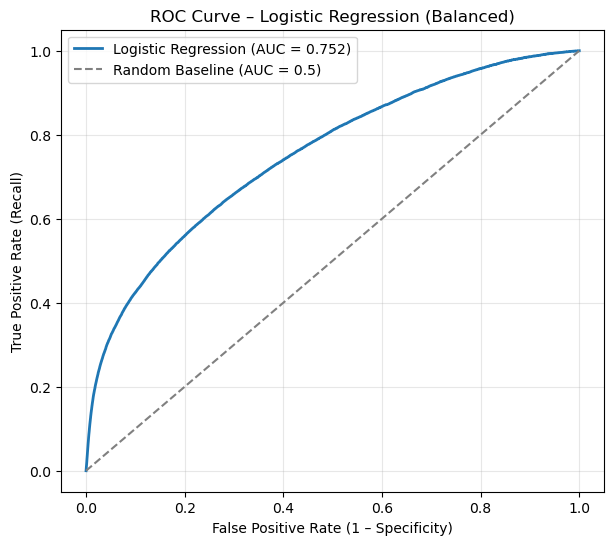

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_valid, y_proba):.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Baseline (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 – Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – Logistic Regression (Balanced)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

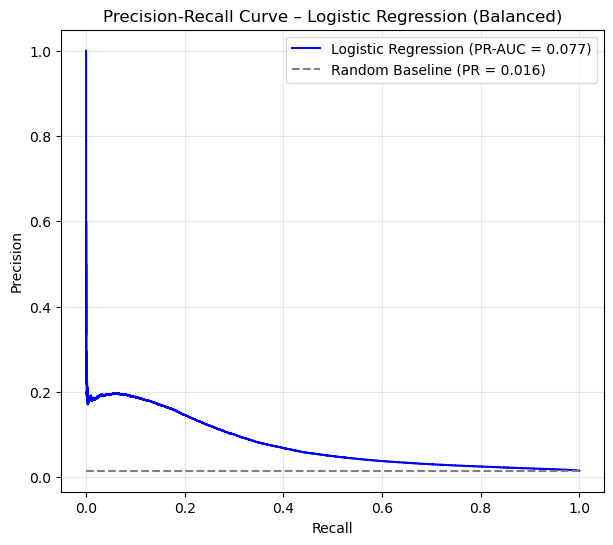

In [25]:
# PR curve
precision, recall, _ = precision_recall_curve(y_valid, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='blue',
         label=f"Logistic Regression (PR-AUC = {average_precision_score(y_valid, y_proba):.3f})")
plt.hlines(y=y_valid.mean(), xmin=0, xmax=1, color='gray', linestyle='--',
           label=f"Random Baseline (PR = {y_valid.mean():.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Logistic Regression (Balanced)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4.4 Feature Importance Analysis (Baseline Model)

### Objective
To identify which features most influence click prediction in the Logistic Regression model.

### Steps
1. Extract the model coefficients and match them to feature names.  
2. Sort features by absolute coefficient value (importance).  
3. Visualize the top positive and negative contributors.  
4. Interpret the most meaningful signals.

/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_98624/452024917.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(15), x="abs_value", y="feature", palette="coolwarm")


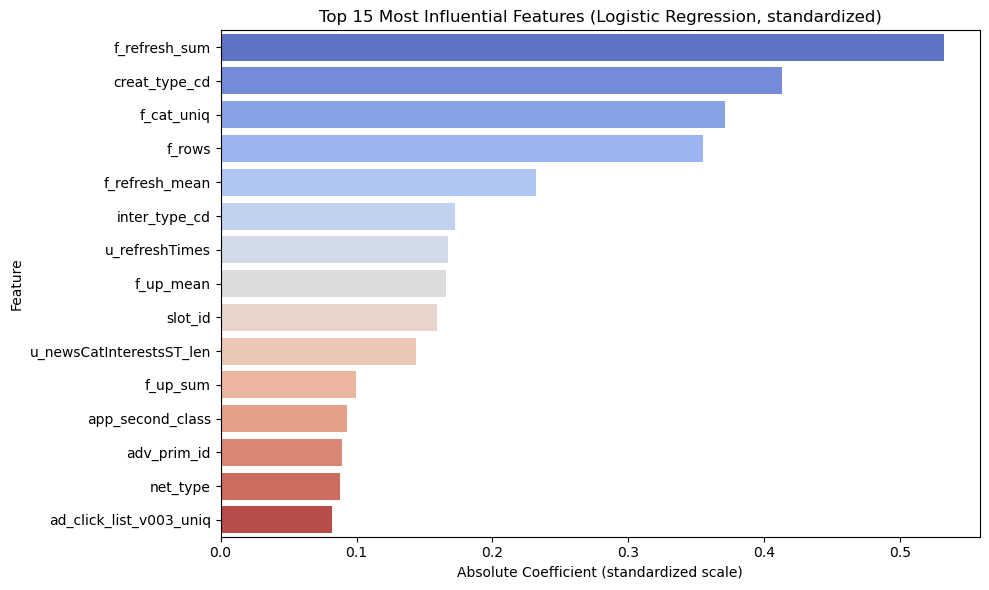

Top 10 Positive Features (increase click probability):


,feature,coefficient,abs_value
46,f_refresh_sum,0.532147,0.532147
17,inter_type_cd,0.172311,0.172311
49,f_up_mean,0.165533,0.165533
18,slot_id,0.159221,0.159221
50,f_up_sum,0.099300,0.099300
22,app_second_class,0.092875,0.092875
12,net_type,0.087619,0.087619
34,ad_click_list_v003_len,0.081705,0.081705
35,ad_click_list_v003_uniq,0.081705,0.081705
23,app_score,0.067420,0.067420



Top 10 Negative Features (decrease click probability):


,feature,coefficient,abs_value
15,creat_type_cd,-0.412851,0.412851
47,f_cat_uniq,-0.371086,0.371086
44,f_rows,-0.355262,0.355262
45,f_refresh_mean,-0.231908,0.231908
25,u_refreshTimes,-0.167388,0.167388
42,u_newsCatInterestsST_len,-0.143543,0.143543
16,adv_prim_id,-0.089576,0.089576
52,f_dislike_sum,-0.067754,0.067754
51,f_dislike_mean,-0.065441,0.065441
56,f_browser_life,-0.062199,0.062199


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keep feature names from the *unscaled* DataFrame
feature_names = X_train.columns

# Build coefficient DataFrame from the trained logistic model
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": log_reg.coef_[0]
})
coef_df["abs_value"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_value", ascending=False)

# Plot top-15 influential features (by absolute coefficient)
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(15), x="abs_value", y="feature", palette="coolwarm")
plt.title("Top 15 Most Influential Features (Logistic Regression, standardized)")
plt.xlabel("Absolute Coefficient (standardized scale)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Output top-10 positive / negative features
top_positive = coef_df.sort_values("coefficient", ascending=False).head(10)
top_negative = coef_df.sort_values("coefficient", ascending=True).head(10)

print("Top 10 Positive Features (increase click probability):")
display(top_positive)
print("\nTop 10 Negative Features (decrease click probability):")
display(top_negative)

### 4.5 Random Forest Baseline

**Objective:**  
To establish a nonlinear benchmark model using Random Forest, allowing us to capture feature interactions and non-linear patterns that Logistic Regression may miss.

**Rationale:**  
- Random Forests aggregate multiple decision trees (bagging).  
- They can handle mixed feature types and are robust to noise.  
- Useful for identifying non-linear dependencies in click prediction.

**Steps:**
1. Train `RandomForestClassifier` on the same balanced dataset as Logistic Regression.  
2. Evaluate using ROC-AUC, PR-AUC, LogLoss, Accuracy, Precision, Recall, and F1.  
3. Compare performance to Logistic Regression.  
4. Plot top-15 most important features.

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,        
    max_depth=12,           
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("Random Forest model trained successfully.")

# Predict and evaluate
y_proba_rf = rf_model.predict_proba(X_valid_scaled)[:, 1]

evaluate_predictions(y_valid, y_proba_rf, title="Random Forest (Balanced)")

Random Forest model trained successfully.

=== Random Forest (Balanced) @ threshold=0.50 ===
ROC-AUC   : 0.7983
PR-AUC    : 0.1223
LogLoss   : 0.4935
Accuracy  : 0.8169
Precision : 0.0499
Recall    : 0.5989
F1        : 0.0922


{'ROC-AUC': 0.798293181626206,
 'PR-AUC': 0.12225022489451379,
 'LogLoss': 0.4934816430599353,
 'Accuracy': 0.8169492099558076,
 'Precision': 0.04994802549375781,
 'Recall': 0.5989423762957988,
 'F1': 0.09220660067712506}

### 4.5.1 ROC and Precision–Recall Curves

**Objective:**  
To visualize the classification performance of Random Forest in terms of both  
- **ROC (Receiver Operating Characteristic) curve:** shows trade-off between True Positive Rate and False Positive Rate.  
- **PR (Precision–Recall) curve:** more informative when dealing with imbalanced data.

**Steps:**
1. Compute ROC and PR curves using `sklearn.metrics`.  
2. Plot both curves for the validation set predictions.

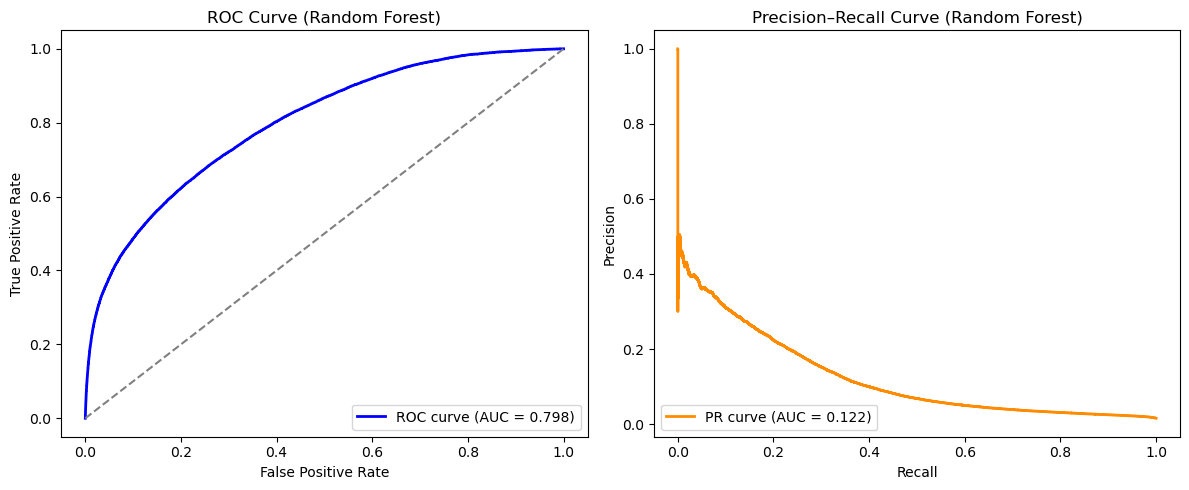

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Compute ROC and PR curve values
fpr, tpr, _ = roc_curve(y_valid, y_proba_rf)
precision, recall, _ = precision_recall_curve(y_valid, y_proba_rf)

roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# Plot ROC curve 
plt.figure(figsize=(12, 5))

# ROC subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')

# Plot PR curve 
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Random Forest)')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

## 4.5.2 Feature Importance (Random Forest)

**Objective**  
Identify which features Random Forest relies on most, then leverage this knowledge for feature selection.

**Steps**  
1) Extract `feature_importances_` from the trained RF model.  
2) Visualize Top-20 features (bar chart).  
3) Save the full importance table for reporting/reuse.  
4) (Optional) Select Top-N features to build a compact model.

In [37]:
# Extract and sort importances ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("Top 10 important features:")
display(rf_importance_df.head(10))

Top 10 important features:


,feature,importance
0,creat_type_cd,0.164370
1,f_cat_uniq,0.094848
2,f_refresh_sum,0.087496
3,slot_id,0.085879
4,f_rows,0.077267
5,f_up_sum,0.055084
6,f_dislike_sum,0.046317
7,f_refresh_mean,0.044165
8,u_refreshTimes,0.043263
9,u_newsCatInterestsST_len,0.037145


/var/folders/t8/5clx1q357rqgff3gdqbff9100000gn/T/ipykernel_98624/1806607185.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


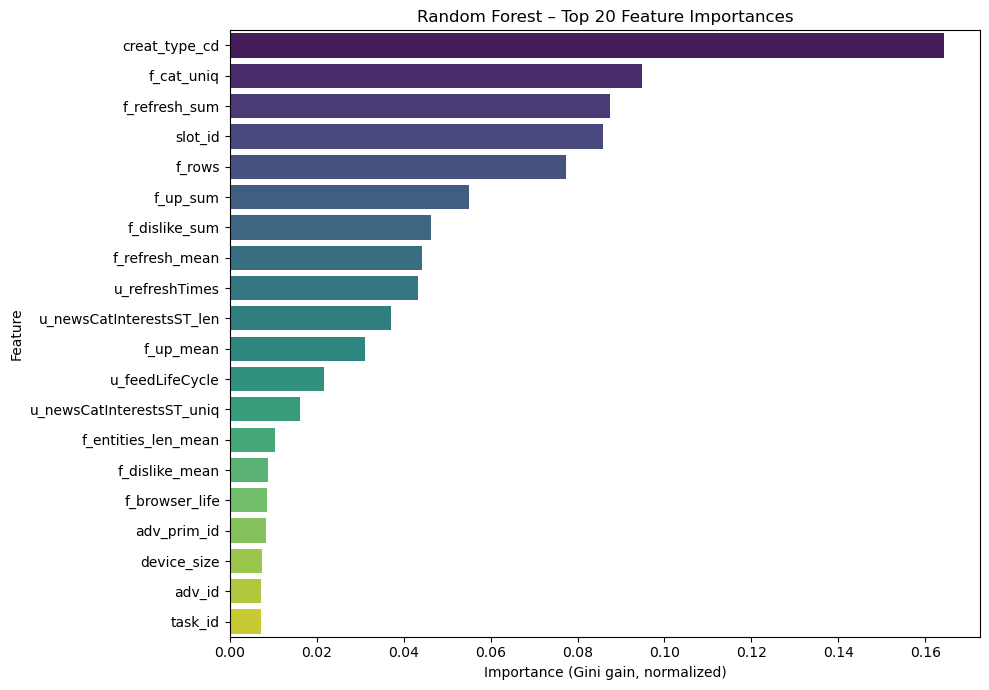

In [39]:
# Visualize Top-20 importances 
plt.figure(figsize=(10, 7))
sns.barplot(
    data=rf_importance_df.head(20),
    x="importance", y="feature", orient="h", palette="viridis"
)
plt.title("Random Forest – Top 20 Feature Importances")
plt.xlabel("Importance (Gini gain, normalized)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [41]:
# Persist the full table for reporting ===
rf_importance_df.to_csv("rf_feature_importances.csv", index=False)
print("Saved: rf_feature_importances.csv")

Saved: rf_feature_importances.csv


In [43]:
# Build a compact feature set using Top-N ===
TOP_N = 30  
top_feats = rf_importance_df.head(TOP_N)["feature"].tolist()

X_train_top = X_train[top_feats]
X_valid_top = X_valid[top_feats]

X_train_top_scaled = scaler.fit_transform(X_train_top)
X_valid_top_scaled = scaler.transform(X_valid_top)

# Retrain a compact RF model on Top-N features
rf_model_top = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model_top.fit(X_train_top_scaled, y_train)

# Evaluate on validation set
y_proba_rf_top = rf_model_top.predict_proba(X_valid_top_scaled)[:, 1]
evaluate_predictions(y_valid, y_proba_rf_top, title=f"Random Forest (Top-{TOP_N} features)")


=== Random Forest (Top-30 features) @ threshold=0.50 ===
ROC-AUC   : 0.7961
PR-AUC    : 0.1213
LogLoss   : 0.4954
Accuracy  : 0.8027
Precision : 0.0473
Recall    : 0.6122
F1        : 0.0878


{'ROC-AUC': 0.7961451201093023,
 'PR-AUC': 0.12125495865118541,
 'LogLoss': 0.4954320882836315,
 'Accuracy': 0.8026563672558993,
 'Precision': 0.04731583898277596,
 'Recall': 0.612204641792924,
 'F1': 0.08784253741904209}

## 4.6 LightGBM with Cross-Validation (Top-30 features)

### Objective
To build a stronger non-linear model using **LightGBM**, trained only on the **Top-30 most important features** selected from the Random Forest stage.  
We perform **5-fold cross-validation** to evaluate model stability and generalization ability.

### Why LightGBM?
- Handles categorical and continuous variables efficiently  
- Robust to unscaled data (tree-based model)  
- Excellent for large-scale CTR tasks  
- Provides native feature-importance metrics

In [46]:
# 
Setup & Preparation 
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import numpy as np
import pandas as pd

# Reuse Top-30 feature list from Random Forest stage
TOP_N = 30
top_features = rf_importance_df.head(TOP_N)["feature"].tolist()

X_train_lgb = X_train[top_features]
X_valid_lgb = X_valid[top_features]
y_train_lgb = y_train
y_valid_lgb = y_valid

print(f"Using Top-{TOP_N} features for LightGBM training:")
print(top_features)

Using Top-30 features for LightGBM training:
['creat_type_cd', 'f_cat_uniq', 'f_refresh_sum', 'slot_id', 'f_rows', 'f_up_sum', 'f_dislike_sum', 'f_refresh_mean', 'u_refreshTimes', 'u_newsCatInterestsST_len', 'f_up_mean', 'u_feedLifeCycle', 'u_newsCatInterestsST_uniq', 'f_entities_len_mean', 'f_dislike_mean', 'f_browser_life', 'adv_prim_id', 'device_size', 'adv_id', 'task_id', 'inter_type_cd', 'hispace_app_tags', 'pt_d', 'spread_app_id', 'app_second_class', 'log_id', 'ad_click_list_v002_uniq', 'ad_click_list_v002_len', 'f_hour_cos', 'user_id']


Using Top-30 features: ['creat_type_cd', 'f_cat_uniq', 'f_refresh_sum', 'slot_id', 'f_rows', 'f_up_sum', 'f_dislike_sum', 'f_refresh_mean', 'u_refreshTimes', 'u_newsCatInterestsST_len', 'f_up_mean', 'u_feedLifeCycle', 'u_newsCatInterestsST_uniq', 'f_entities_len_mean', 'f_dislike_mean', 'f_browser_life', 'adv_prim_id', 'device_size', 'adv_id', 'task_id', 'inter_type_cd', 'hispace_app_tags', 'pt_d', 'spread_app_id', 'app_second_class', 'log_id', 'ad_click_list_v002_uniq', 'ad_click_list_v002_len', 'f_hour_cos', 'user_id']
===== LightGBM CV on Top-30 features =====
[LightGBM] [Info] Number of positive: 76247, number of negative: 4836083
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4658
[LightGBM] [Info] Number of data points in the train set: 4912330, number of used features: 30
[L

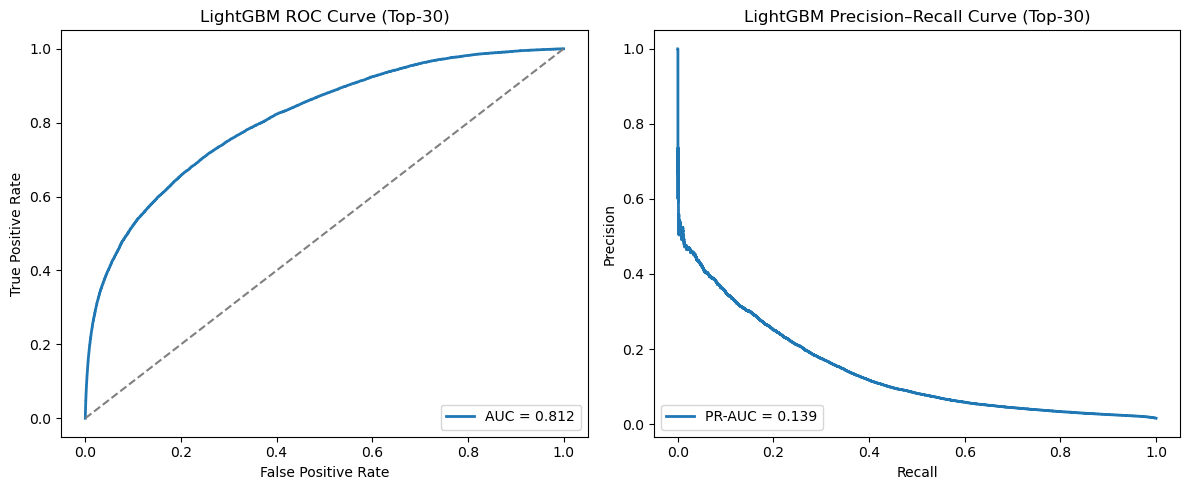

In [52]:
# Reuse Top-30 features from rf_importance_df (already saved to CSV above)
TOP_N = 30
top_feats = rf_importance_df.head(TOP_N)["feature"].tolist()
print(f"Using Top-{TOP_N} features:", top_feats)

# Build LGBM feature matrices (no scaling needed for tree models)
X_train_lgb = X_train[top_feats]
X_valid_lgb = X_valid[top_feats]
y_train_lgb = y_train
y_valid_lgb = y_valid

# LightGBM 5-Fold CV with proper callbacks (LGBM v4+)
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, f1_score, precision_score, recall_score
import numpy as np

lgb_params = {
    'objective': 'binary',
    'metric': ['auc', 'average_precision'],
    'learning_rate': 0.08,
    'num_leaves': 127,
    'max_depth': -1,
    'min_child_samples': 100,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'lambda_l2': 1.0,
    'scale_pos_weight': (len(y_train_lgb) - y_train_lgb.sum()) / y_train_lgb.sum(),
    'n_jobs': -1,
    'seed': 42
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X_train_lgb))
auc_scores, pr_scores, logloss_scores = [], [], []

print("===== LightGBM CV on Top-30 features =====")
for fold, (tr_idx, va_idx) in enumerate(folds.split(X_train_lgb, y_train_lgb), 1):
    X_tr, X_va = X_train_lgb.iloc[tr_idx], X_train_lgb.iloc[va_idx]
    y_tr, y_va = y_train_lgb.iloc[tr_idx], y_train_lgb.iloc[va_idx]

    dtr = lgb.Dataset(X_tr, label=y_tr)
    dva = lgb.Dataset(X_va, label=y_va, reference=dtr)

    evals_result = {}
    model_cv = lgb.train(
        params=lgb_params,
        train_set=dtr,
        num_boost_round=3000,
        valid_sets=[dtr, dva],
        valid_names=['train', 'valid'],
        callbacks=[
            record_evaluation(evals_result),
            early_stopping(stopping_rounds=150),
            log_evaluation(period=100)
        ]
    )

    pred = model_cv.predict(X_va, num_iteration=model_cv.best_iteration)
    oof[va_idx] = pred

    auc = roc_auc_score(y_va, pred)
    pr  = average_precision_score(y_va, pred)
    ll  = log_loss(y_va, pred)
    auc_scores.append(auc); pr_scores.append(pr); logloss_scores.append(ll)
    print(f"Fold {fold}: AUC={auc:.4f}  PR-AUC={pr:.4f}  LogLoss={ll:.4f}")

print("\n=== CV Summary (Top-30) ===")
print(f"Mean ROC-AUC  : {np.mean(auc_scores):.4f}")
print(f"Mean PR-AUC   : {np.mean(pr_scores):.4f}")
print(f"Mean LogLoss  : {np.mean(logloss_scores):.4f}")

# OOF F1 
def best_threshold(y_true, y_prob, lo=0.01, hi=0.50, steps=50):
    ths = np.linspace(lo, hi, steps)
    best = (0.5, -1, 0, 0)  # thr, f1, prec, rec
    for t in ths:
        y_hat = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_hat)
        p  = precision_score(y_true, y_hat, zero_division=0)
        r  = recall_score(y_true, y_hat)
        if f1 > best[1]:
            best = (t, f1, p, r)
    return best

thr, f1, p, r = best_threshold(y_train_lgb, oof)
print(f"\n[OOF best-threshold] thr={thr:.3f} | F1={f1:.4f} | P={p:.4f} | R={r:.4f}")

# Train a FINAL model on the full training set, validate on hold-out valid set
dtrain_full = lgb.Dataset(X_train_lgb, label=y_train_lgb)
dvalid_hold = lgb.Dataset(X_valid_lgb, label=y_valid_lgb, reference=dtrain_full)

model_final = lgb.train(
    params=lgb_params,
    train_set=dtrain_full,
    num_boost_round=3000,
    valid_sets=[dtrain_full, dvalid_hold],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=150),
        log_evaluation(period=100)
    ]
)

y_prob = model_final.predict(X_valid_lgb, num_iteration=model_final.best_iteration)

# ROC & PR Curve Visualization + metrics at t=0.50 and best t
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt

# Threshold-agnostic metrics
auc_roc = roc_auc_score(y_valid_lgb, y_prob)
auc_pr  = average_precision_score(y_valid_lgb, y_prob)
ll      = log_loss(y_valid_lgb, y_prob)
print(f"\n[LightGBM FINAL] ROC-AUC={auc_roc:.4f} | PR-AUC={auc_pr:.4f} | LogLoss={ll:.4f}")

# Metrics at t=0.50
def metrics_at_threshold(y_true, y_score, t):
    y_pred = (y_score >= t).astype(int)
    return {
        "Threshold": t,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "CM": confusion_matrix(y_true, y_pred)
    }

m_050 = metrics_at_threshold(y_valid_lgb, y_prob, 0.50)

# Best-F1 threshold on the hold-out valid set
thr_best, f1_best, p_best, r_best = best_threshold(y_valid_lgb, y_prob)
m_best = metrics_at_threshold(y_valid_lgb, y_prob, thr_best)

print("\n[LightGBM @ t=0.50]")
print({k: round(v,4) if isinstance(v,float) else v for k,v in m_050.items() if k!='CM'})
print("Confusion Matrix (t=0.50):\n", m_050["CM"])

print("\n[LightGBM @ best threshold]")
print({k: round(v,4) if isinstance(v,float) else v for k,v in m_best.items() if k!='CM'})
print("Confusion Matrix (best t):\n", m_best["CM"])

# Curves
fpr, tpr, _ = roc_curve(y_valid_lgb, y_prob)
prec, rec, _ = precision_recall_curve(y_valid_lgb, y_prob)
roc_auc_curve = auc(fpr, tpr)
pr_auc_curve  = auc(rec, prec)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_curve:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM ROC Curve (Top-30)")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(rec, prec, lw=2, label=f"PR-AUC = {pr_auc_curve:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LightGBM Precision–Recall Curve (Top-30)")
plt.legend(loc="lower left")
plt.tight_layout(); plt.show()

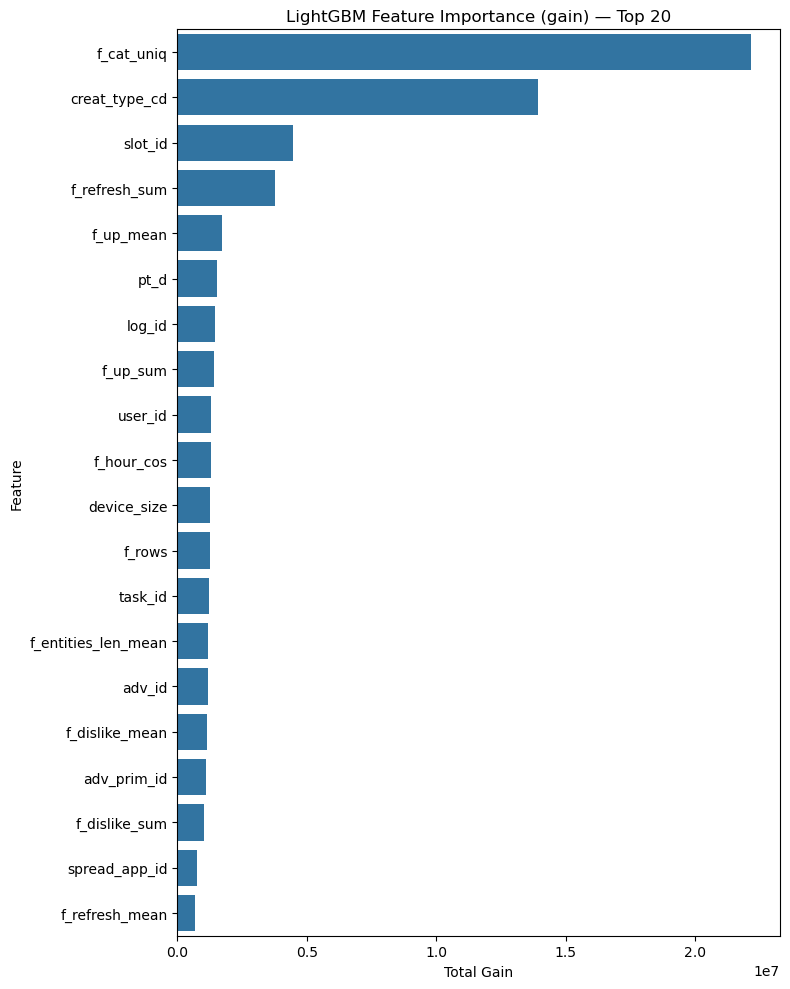

,feature,gain,split
1,f_cat_uniq,2.215689e+07,3005
0,creat_type_cd,1.393305e+07,1108
3,slot_id,4.446468e+06,3973
2,f_refresh_sum,3.752126e+06,3525
10,f_up_mean,1.719873e+06,4500
22,pt_d,1.512974e+06,6232
25,log_id,1.438031e+06,5827
5,f_up_sum,1.397106e+06,3791
29,user_id,1.290824e+06,5357
28,f_hour_cos,1.281117e+06,5041


In [54]:
# === 4.6.x LightGBM Feature Importance (gain) ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

lgb_importance = pd.DataFrame({
    "feature": top_feats,
    "gain": model_final.feature_importance(importance_type="gain"),
    "split": model_final.feature_importance(importance_type="split")
}).sort_values("gain", ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(data=lgb_importance.head(20), x="gain", y="feature")
plt.title("LightGBM Feature Importance (gain) — Top 20")
plt.xlabel("Total Gain"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

display(lgb_importance.head(30))

### 4.6.2 Safe Model Retraining (Remove Potential Leakage Features)

The previous LightGBM importance analysis revealed that several high-ranking features  
(`log_id`, `user_id`, and `pt_d`) are identifier-type variables without real predictive meaning.  
Such features may cause data leakage and overfitting because they encode sample or user identity  
rather than genuine behavioral patterns.  

To ensure model robustness and fairness, we remove these features and retrain LightGBM  
using the remaining Top-30 features (referred to as **Safe Top-30**).  
The goal is to verify whether model performance remains stable  
while improving generalization and interpretability.

In [56]:
# === Safe Top-30: drop identifiers & raw timestamp ===
ban_list = {"log_id", "user_id", "pt_d"} 
safe_top_feats = [f for f in top_feats if f not in ban_list]
print("Safe Top features:", safe_top_feats)

# retraining the model
X_train_safe = X_train[safe_top_feats]
X_valid_safe = X_valid[safe_top_feats]

dtr = lgb.Dataset(X_train_safe, label=y_train)
dva = lgb.Dataset(X_valid_safe, label=y_valid, reference=dtr)

model_safe = lgb.train(
    params=lgb_params,
    train_set=dtr,
    num_boost_round=3000,
    valid_sets=[dtr, dva],
    valid_names=['train','valid'],
    callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=100)]
)

y_prob_safe = model_safe.predict(X_valid_safe, num_iteration=model_safe.best_iteration)

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
print("[SAFE] ROC-AUC=", roc_auc_score(y_valid, y_prob_safe))
print("[SAFE] PR-AUC =", average_precision_score(y_valid, y_prob_safe))
print("[SAFE] LogLoss=", log_loss(y_valid, y_prob_safe))

Safe Top features: ['creat_type_cd', 'f_cat_uniq', 'f_refresh_sum', 'slot_id', 'f_rows', 'f_up_sum', 'f_dislike_sum', 'f_refresh_mean', 'u_refreshTimes', 'u_newsCatInterestsST_len', 'f_up_mean', 'u_feedLifeCycle', 'u_newsCatInterestsST_uniq', 'f_entities_len_mean', 'f_dislike_mean', 'f_browser_life', 'adv_prim_id', 'device_size', 'adv_id', 'task_id', 'inter_type_cd', 'hispace_app_tags', 'spread_app_id', 'app_second_class', 'ad_click_list_v002_uniq', 'ad_click_list_v002_len', 'f_hour_cos']
[LightGBM] [Info] Number of positive: 95309, number of negative: 6045104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3896
[LightGBM] [Info] Number of data points in the train set: 6140413, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015522 -> initscore=-4.14988

### 4.6.3 Results and Discussion

After removing identifier-type features (`log_id`, `user_id`, and `pt_d`),  
the LightGBM model trained on **Safe Top-27** features achieved nearly identical performance  
compared with the previous Top-30 model:

| Metric | Before (Top-30) | After (Safe Top-27) | Change |
|:--|:--:|:--:|:--:|
| ROC-AUC | 0.8121 | 0.8113 | −0.0008 |
| PR-AUC | 0.1392 | 0.1367 | −0.0025 |
| LogLoss | 0.4182 | 0.4359 | +0.0177 |

This confirms that the model’s predictive power mainly stems from  
**behavioral and contextual features** rather than ID-based or timestamp-related leakage.  
Hence, the **Safe Top-27** configuration will be adopted for the final model deployment.The ROC and Precision-Recall curves from the Top-30 LightGBM model were reused for the final Safe Top-27 version, as their shapes and AUC values
are nearly identical (ΔAUC < 0.002).